<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;">
<img src="https://raw.githubusercontent.com/Unidata/MetPy/master/metpy/plots/_static/unidata_150x150.png" alt="Unidata Logo" style="height: 98px;">
</div>

<h1>Using Siphon to query the NetCDF Subset Service</h1>
<h3>Unidata Python Workshop</h3>

<div style="clear:both"></div>
</div>

<hr style="height:2px;">

### Objectives
1. Learn what Siphon is
2. Employ Siphon's NCSS class to retrieve data from a THREDDS Data Server (TDS)
3. Plot a map using numpy arrays, matplotlib, and cartopy!

### Introduction:
Siphon is a python package that makes downloading data from Unidata data technologies a breeze! In our examples, we'll focus on interacting with the netCDF Subset Service (NCSS) as well as the radar server to retrieve grid data and radar data. 

**But first!**
Bookmark these resources for when you want to use Siphon later!
+ [latest Siphon documentation](http://siphon.readthedocs.org/en/latest/)
+ [Siphon github repo](https://github.com/Unidata/siphon)
+ [TDS documentation](http://www.unidata.ucar.edu/software/thredds/v4.6/tds/TDS.html)
+ [netCDF subset service documentation](http://www.unidata.ucar.edu/software/thredds/current/tds/reference/NetcdfSubsetServiceReference.html)

### Let's get started!

First, we'll import the TDSCatalog class from Siphon and put the special 'matplotlib' line in so our map will show up later in the notebook. Let's construct an instance of TDSCatalog pointing to our dataset of interest. In this case, I've chosen the TDS' "Best" virtual dataset for the GFS global 0.25 degree collection of GRIB files. This will give us a good resolution for our map. This catalog contains a single dataset.

In [1]:
%matplotlib inline
from siphon.catalog import TDSCatalog
best_gfs = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/'
                      'Global_0p25deg/catalog.xml?dataset=grib/NCEP/GFS/Global_0p25deg/Best')
best_gfs.datasets

DatasetCollection([('Best GFS Quarter Degree Forecast Time Series',
                    Best GFS Quarter Degree Forecast Time Series)])

We pull out this dataset and look at the access urls. Note there are many ways to access the data. 

In [2]:
best_ds = list(best_gfs.datasets.values())[0]
best_ds.access_urls

{'CdmRemote': 'http://thredds.ucar.edu/thredds/cdmremote/grib/NCEP/GFS/Global_0p25deg/Best',
 'ISO': 'http://thredds.ucar.edu/thredds/iso/grib/NCEP/GFS/Global_0p25deg/Best',
 'NCML': 'http://thredds.ucar.edu/thredds/ncml/grib/NCEP/GFS/Global_0p25deg/Best',
 'NetcdfSubset': 'http://thredds.ucar.edu/thredds/ncss/grib/NCEP/GFS/Global_0p25deg/Best',
 'OPENDAP': 'http://thredds.ucar.edu/thredds/dodsC/grib/NCEP/GFS/Global_0p25deg/Best',
 'UDDC': 'http://thredds.ucar.edu/thredds/uddc/grib/NCEP/GFS/Global_0p25deg/Best',
 'WCS': 'http://thredds.ucar.edu/thredds/wcs/grib/NCEP/GFS/Global_0p25deg/Best',
 'WMS': 'http://thredds.ucar.edu/thredds/wms/grib/NCEP/GFS/Global_0p25deg/Best'}

The `NetcdfSubset` entry is what we're after...we'll use this in our NCSS class. Let's import the NCSS class from Siphon and then pass in the NetcdfSubset access url. 

In [3]:
from siphon.ncss import NCSS
ncss = NCSS(best_ds.access_urls['NetcdfSubset'])

We can then use the `ncss` object to create a new query object, which
facilitates asking for data from the server.

In [4]:
query = ncss.query()

We can look at the `ncss.variables` object to see what variables are available from the dataset:

In [5]:
ncss.variables

{'5-Wave_Geopotential_Height_isobaric',
 'Absolute_vorticity_isobaric',
 'Albedo_surface_Mixed_intervals_Average',
 'Apparent_temperature_height_above_ground',
 'Best_4_layer_Lifted_Index_surface',
 'Categorical_Freezing_Rain_surface_Mixed_intervals_Average',
 'Categorical_Ice_Pellets_surface_Mixed_intervals_Average',
 'Categorical_Rain_surface_Mixed_intervals_Average',
 'Categorical_Snow_surface_Mixed_intervals_Average',
 'Cloud_Work_Function_entire_atmosphere_single_layer_Mixed_intervals_Average',
 'Cloud_mixing_ratio_isobaric',
 'Cloud_water_entire_atmosphere_single_layer',
 'Convective_Precipitation_Rate_surface_Mixed_intervals_Average',
 'Convective_available_potential_energy_pressure_difference_layer',
 'Convective_available_potential_energy_surface',
 'Convective_inhibition_pressure_difference_layer',
 'Convective_inhibition_surface',
 'Convective_precipitation_surface_Mixed_intervals_Accumulation',
 'Dewpoint_temperature_height_above_ground',
 'Downward_Long-Wave_Radp_Flux_surf

We construct a query asking for data corresponding to a latitude and longitude box where 43 lat is the northern extent, 35 lat is the southern extent, 260 long is the western extent and 249 is the eastern extent. Note that longitude values are the longitude distance from the prime meridian. We request the data for the current time. This request will return all surface temperatures for points in our bounding box for a single time. Note the string representation of the query is a properly encoded query string.

In [6]:
from datetime import datetime
query.lonlat_box(north=43, south=35, east=260, west=249).time(datetime.utcnow())
query.accept('netcdf4')
query.variables('Temperature_surface')

var=Temperature_surface&time=2018-03-02T18%3A02%3A09.758969&west=249&east=260&south=35&north=43&accept=netcdf4

We now request data from the server using this query. The `NCSS` class handles parsing this NetCDF data (using the `netCDF4` module). If we print out the variable names, we see our requested variables, as well as a few others (more metadata information)

In [7]:
data = ncss.get_data(query)
list(data.variables.keys())

['Temperature_surface', 'reftime1', 'time1', 'lat', 'lon']

We'll pull out the temperature variable.

In [8]:
temp_3d = data.variables['Temperature_surface']

We need to look at the ``coordinates`` attribute to determine the name of the proper time variable for this variable, since the GRIB collection can have multiple time variables.

In [9]:
temp_3d.coordinates

'reftime1 time1 lat lon '

In [10]:
# Helper function for finding proper time variable
def find_time_var(var, time_basename='time'):
    for coord_name in var.coordinates.split():
        if coord_name.startswith(time_basename):
            return coord_name
    raise ValueError('No time variable found for ' + var.name)

In [11]:
time_coord_name = find_time_var(temp_3d)

We'll pull out the useful variables for latitude, and longitude, and time (which is the time, in hours since the forecast run). Notice the variable names are labeled to show how many dimensions each variable is. This will come in to play soon when we prepare to plot. Try printing one of the variables to see some info on the data!

In [12]:
time_1d = data.variables[time_coord_name]
lat_1d = data.variables['lat']
lon_1d = data.variables['lon']
time_1d

<class 'netCDF4._netCDF4.Variable'>
float64 time1(time1)
    units: Hour since 2018-02-28T00:00:00Z
    standard_name: time
    long_name: GRIB forecast or observation time
    calendar: proleptic_gregorian
    _CoordinateAxisType: Time
unlimited dimensions: 
current shape = (1,)
filling on, default _FillValue of 9.969209968386869e+36 used

Now we make our data suitable for plotting. We'll import numpy so we can combine lat/longs (meshgrid) and remove one-dimensional entities from our arrays (squeeze). Also we'll use netCDF4's num2date to change the time since the model run to an actual date. 

In [13]:
import numpy as np
from netCDF4 import num2date
from metpy.units import units

# Reduce the dimensions of the data
temp_2d = temp_3d[:].squeeze() * units(temp_3d.units)
lat_1d = lat_1d[:].squeeze()
lon_1d = lon_1d[:].squeeze()

# Convert the number of hours since the reference time to an actual date
time_val = num2date(time_1d[:].squeeze(), time_1d.units)

# Combine latitude and longitudes 
lon_2d, lat_2d = np.meshgrid(lon_1d, lat_1d)

Now we can plot these up using matplotlib. We import cartopy and matplotlib classes, create our figure, add a map, then add the temperature data and grid points.

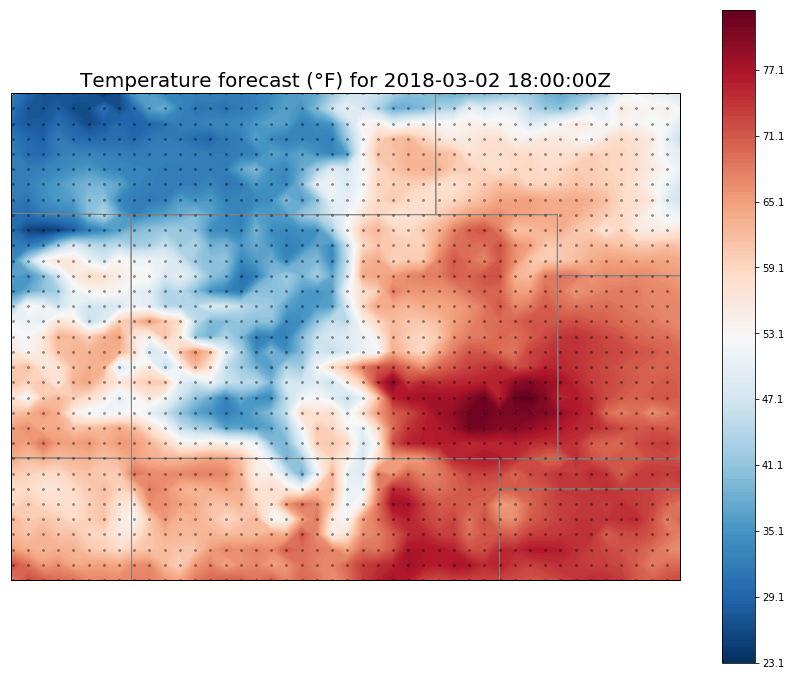

In [14]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from metpy.plots import ctables

# Create a new figure
fig = plt.figure(figsize=(15, 12))

# Add the map and set the extent
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-100.03, -111.03, 35, 43])

# Retrieve the state boundaries using cFeature and add to plot
ax.add_feature(cfeat.STATES, edgecolor='gray')

# Contour temperature at each lat/long
contours = ax.contourf(lon_2d, lat_2d, temp_2d.to('degF'), 200, transform=ccrs.PlateCarree(),
                       cmap='RdBu_r')
#Plot a colorbar to show temperature and reduce the size of it
fig.colorbar(contours)

# Make a title with the time value
ax.set_title(u'Temperature forecast (\u00b0F) for {0}Z'.format(time_val), fontsize=20)

# Plot markers for each lat/long to show grid points for 0.25 deg GFS
ax.plot(lon_2d.flatten(), lat_2d.flatten(), linestyle='none', marker='o',
        color='black', markersize=2, alpha=0.3, transform=ccrs.PlateCarree());

### Exercise
Create your own map using the same projection as above but plot different data variables such as dewpoint or relative humidity.
1. Explore the variables available in the NCSS dataset by printing NCSS.variables
2. Change the latitude/longitude values for the request and the map to a region of your own interest!
3. If you're feeling bold, pass in a different TDSCatalog reference url (such as the GFS half degree). Take a look at the full TDS catalog [here](http://thredds.ucar.edu/thredds/catalog.html).